In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow.keras.utils as krs

In [100]:
p = Path("./images")
dirs = p.glob("*")
labels_dictionary = {"cat":0,"dog":1,"horse":2,"human":3}
image_data = []
labels = []

for folder_dir in dirs:
    print(folder_dir)
    label = str(folder_dir).split('\\')[-1][:-1]
    
    for img_path in folder_dir.glob('*.jpg'):
        img = krs.load_img(img_path, target_size=(32,32))
        img_arr = krs.img_to_array(img)
        image_data.append(img_arr)
        labels.append(labels_dictionary[label])


images\cats
images\dogs
images\horses
images\humans


In [101]:
print(len(labels))
print(len(image_data))

808
808


In [102]:
image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)


In [103]:
print(image_data.shape, labels.shape)

(808, 32, 32, 3) (808,)


Visualize the data

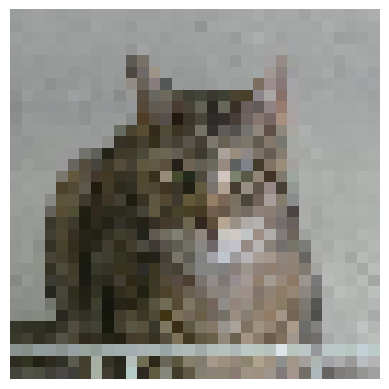

In [104]:
def image_vis(img):
    plt.axis("off")
    plt.imshow(img)

    return

image_vis(image_data[5])

Shuffle the data

In [105]:
import random
combined_data = list(zip(image_data, labels))
random.shuffle(combined_data)

image_data, labels = zip(*combined_data)
image_data = np.array(list(image_data))
labels = np.array(list(labels))

In [106]:
print(image_data.shape)

(808, 32, 32, 3)


In [107]:
print(image_data[5], labels[5])

[[[0.99215686 0.98039216 0.92156863]
  [0.99607843 0.99215686 0.92156863]
  [0.7137255  0.6901961  0.5882353 ]
  ...
  [0.39607844 0.4        0.38039216]
  [0.4509804  0.45490196 0.43529412]
  [0.49411765 0.49803922 0.46666667]]

 [[0.4392157  0.42352942 0.38039216]
  [0.5254902  0.50980395 0.46666667]
  [0.45882353 0.44313726 0.40784314]
  ...
  [0.4        0.4        0.39215687]
  [0.47843137 0.48235294 0.4627451 ]
  [0.41568628 0.41960785 0.4       ]]

 [[0.5019608  0.45882353 0.44313726]
  [0.49019608 0.4627451  0.43137255]
  [0.8627451  0.78039217 0.6745098 ]
  ...
  [0.6901961  0.65882355 0.5686275 ]
  [0.54901963 0.54901963 0.5019608 ]
  [0.48235294 0.4862745  0.43137255]]

 ...

 [[0.36862746 0.41960785 0.48235294]
  [0.4        0.44705883 0.5019608 ]
  [0.23529412 0.29803923 0.35686275]
  ...
  [0.69803923 0.68235296 0.6392157 ]
  [0.8117647  0.8235294  0.78039217]
  [0.80784315 0.8235294  0.81960785]]

 [[0.10196079 0.14509805 0.21568628]
  [0.10588235 0.14901961 0.21960784]


1


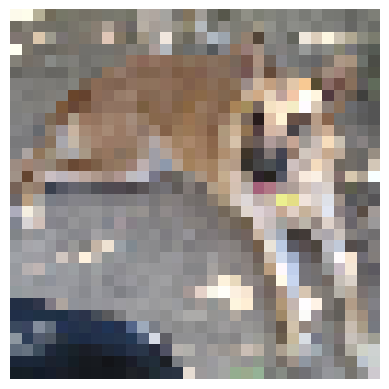

In [108]:
image_vis(image_data[5])
print(labels[5])

In [129]:
class SVM:
    def __init__(self, C=1.0):
        self.C = C
        self.W = 0
        self.b = 0

    def hingeloss(self, W, Y, X, b):
        loss = 0.0
        loss += (np.dot(W,W.T))/2
        for i in range(X.shape[0]):
            ti = Y[i] * (np.dot(W,X[i].T) + b)
            loss += self.C * max(0, (1-ti))
        return loss[0][0]
    
    def fit(self, X, Y, batch_size = 100, learning_rate = 0.001):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]

        n = learning_rate
        c = self.C

        w = np.zeros((1, no_of_features))
        bias = 0
        print(self.hingeloss(w, Y, X, bias))

        losses = []

        for i in range(300):
            l = self.hingeloss(w,Y,X,bias)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)

            for batch_start in range(0, no_of_samples, batch_size):
                gradw = 0
                gradb = 0

                for j in range(batch_start, batch_start+batch_size):
                    if j < no_of_samples:
                        i = ids[j]
                        ti = Y[i]*(np.dot(w,X[i].T)+bias)
                        if ti>1:
                            pass
                        elif ti<1:
                            gradw+= c*Y[i]*X[i]
                            gradb += c*Y[i]

                w = w - learning_rate*w + learning_rate*gradw
                bias = bias + learning_rate*gradb
            losses.append(l)

        self.W = w
        self.b = bias
        return w, bias, losses






One vs one classification

In [130]:
M = image_data.shape[0]
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(808, 3072)
(808,)


In [131]:
no_of_classes = 4
def classwisedata(X,Y):
    data = {}
    for i in range(4):
        data[i] = []

    for i in range(image_data.shape[0]):
        data[Y[i]].append(X[i])

    for j in data.keys():
        data[j] = np.array(data[j])

    return data

In [132]:
data = classwisedata(image_data, labels)
print(data[3].shape[0])

202


creating data pairs for one vs one classification method

In [133]:
def getpairforsvm(d1,d2):
    print(d1.shape)
    print(d2.shape)
    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    data_pair = np.zeros((samples, features))
    data_labels = np.zeros((samples,))

    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2

    data_labels[:l1] = -1
    data_labels[l1:] = +1

    return data_labels, data_pair

In [134]:
mySVM = SVM()

def trainSVM(X,Y):
    svm_classifier = {}
    for i in range(4):
        svm_classifier[i] = {}
        for j in range(i+1, 4):
            Ypair, Xpair = getpairforsvm(data[i], data[j])
            w,b,loss = mySVM.fit(Xpair, Ypair)
            svm_classifier[i][j] = (w,b)

    return svm_classifier

In [135]:
svm_classifier = trainSVM(image_data, labels)

(202, 3072)
(202, 3072)
404.0
(202, 3072)
(202, 3072)
404.0
(202, 3072)
(202, 3072)
404.0
(202, 3072)
(202, 3072)
404.0
(202, 3072)
(202, 3072)
404.0
(202, 3072)
(202, 3072)
404.0


In [124]:
image_data.shape

(808, 3072)

In [137]:
cats_dogs = svm_classifier[0][1]
print(cats_dogs[0].shape)
print(cats_dogs[1])

(1, 3072)
-0.43399999999999955


In [149]:
def binarypredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z >= 0:
        return 1
    else:
        return 0

In [152]:
def predict(X):
    count = np.zeros((4,))

    for i in range(4):
        for j in range(i+1, 4):
            w,b = svm_classifier[i][j]
            z = binarypredict(X,w,b)
            if z == 1:
                count[j] += 1
            else:
                count[i] += 1
    final_prediction = np.argmax(count)
    return final_prediction

In [157]:
print(predict(image_data[0]))
print(labels[0])

3
3
